# Task 1

In [1]:
# Step 1: Import Dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Step 2: Load and Preprocess the MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])

# Download dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train + val (90% / 10%)
train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_data, val_data = random_split(train_dataset, [train_len, val_len])


In [3]:
# Step 3: Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [4]:
# Step 4: Define Your CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN()
device = torch.device("cuda")
model.to(device)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [5]:
# Step 5: Setup Training Utilities
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Step 6: Train the Model
def train(model, loader):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(loader.dataset)
    return running_loss / len(loader.dataset), accuracy


In [7]:
# Run training
EPOCHS = 10
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 - Train Loss: 0.1659, Val Loss: 0.0577, Val Acc: 0.9820
Epoch 2/10 - Train Loss: 0.0555, Val Loss: 0.0486, Val Acc: 0.9847
Epoch 3/10 - Train Loss: 0.0398, Val Loss: 0.0416, Val Acc: 0.9887
Epoch 4/10 - Train Loss: 0.0330, Val Loss: 0.0351, Val Acc: 0.9880
Epoch 5/10 - Train Loss: 0.0253, Val Loss: 0.0308, Val Acc: 0.9915
Epoch 6/10 - Train Loss: 0.0212, Val Loss: 0.0382, Val Acc: 0.9890
Epoch 7/10 - Train Loss: 0.0190, Val Loss: 0.0408, Val Acc: 0.9887
Epoch 8/10 - Train Loss: 0.0154, Val Loss: 0.0361, Val Acc: 0.9892
Epoch 9/10 - Train Loss: 0.0143, Val Loss: 0.0437, Val Acc: 0.9885
Epoch 10/10 - Train Loss: 0.0115, Val Loss: 0.0418, Val Acc: 0.9910


In [8]:
# Step 7: Evaluate on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall Accuracy
test_acc = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {test_acc:.4f}")

# Class-wise Accuracy
for i in range(10):
    idx = all_labels == i
    class_acc = np.mean(all_preds[idx] == all_labels[idx])
    print(f"Class {i} Accuracy: {class_acc:.4f}")


Test Accuracy: 0.9905
Class 0 Accuracy: 0.9980
Class 1 Accuracy: 1.0000
Class 2 Accuracy: 0.9893
Class 3 Accuracy: 0.9980
Class 4 Accuracy: 0.9969
Class 5 Accuracy: 0.9877
Class 6 Accuracy: 0.9833
Class 7 Accuracy: 0.9912
Class 8 Accuracy: 0.9774
Class 9 Accuracy: 0.9812


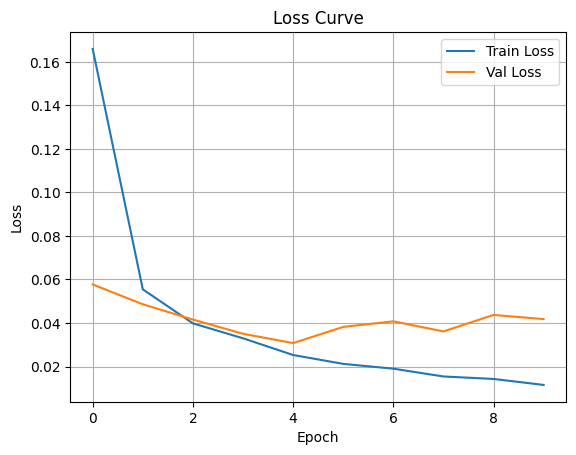

In [9]:
# Step 8: Plot the Loss Curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


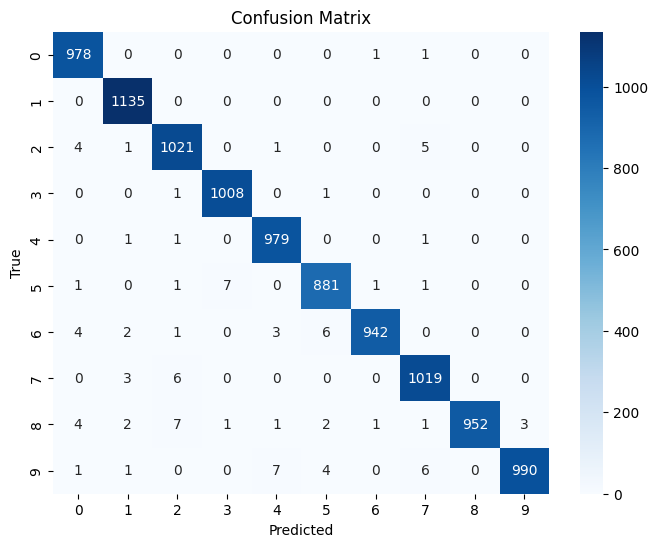

In [10]:
# Optional: Confusion Matrix for Class-wise Behavior
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Validation Loss decreases initially but then starts fluctuating and does not improve after a few epochs, and eventually starts diverging slightly from the train loss. This means that overfitting has occurred in the model since it stops generalizing better on the validation set. The gap between training and validation loss becomes noticeable after epoch 4–5.

To reduce overfitting:
- Increase Dropout: Try increasing dropout in self.dropout = nn.Dropout(0.25) to 0.4 or 0.5.
- Add Data Augmentation: Use RandomRotation, RandomAffine, etc. to augment MNIST images.
- Early Stopping: Stop training when validation loss stops improving.
- Reduce Model Capacity Slightly: The current model might be slightly too powerful for MNIST.

# Task 2

In [20]:
# !pip install transformers
# !pip install torchvision
# !pip install timm

In [21]:
# !pip install tokenizers==0.20.0
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests

In [22]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

In [23]:
def generate_caption(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(model.device)
    output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)
    
    plt.imshow(image)
    plt.title(caption)
    plt.axis("off")
    plt.show()
    
    return caption

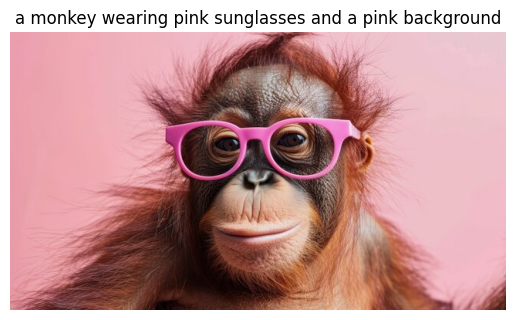

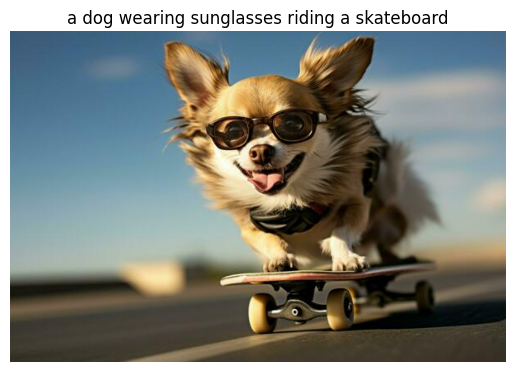

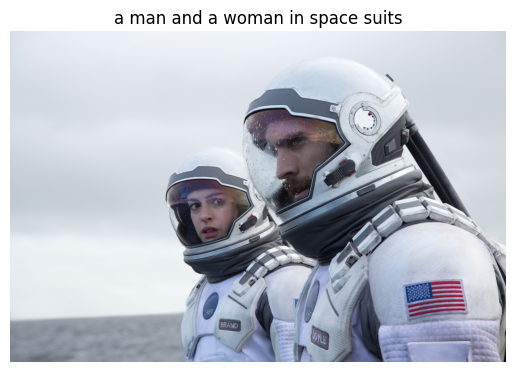

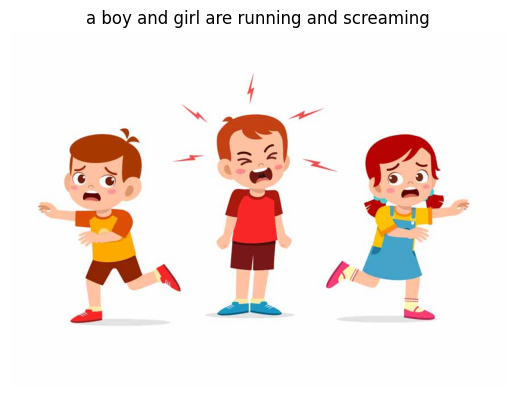

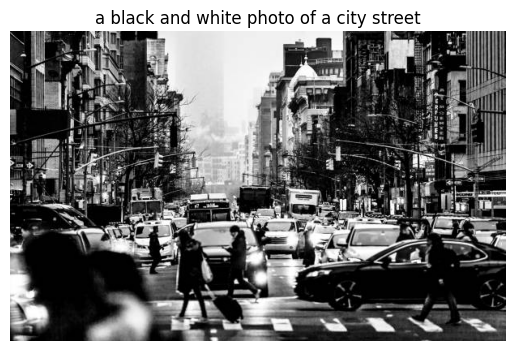

In [24]:
for i in range(1, 6):
    generate_caption(f"data\problem 2\problem_2_{i}.jpg")

# Task 3

In [25]:
def computeM(image_path, Wa, Wb):
    # Step 1: Load image, convert to grayscale, resize
    img = Image.open(image_path).convert('L').resize((224, 224))
    img_np = np.array(img) / 255.0  # Normalize pixel values
    
    # Step 2: Extract 16x16 patches
    patches = []
    for i in range(0, 224, 16):
        for j in range(0, 224, 16):
            patch = img_np[i:i+16, j:j+16].flatten()
            patches.append(patch)
    patches = np.array(patches)  # Shape: (196, 256)

    # Step 3: Compute a = Wa @ f, b = Wb @ f
    A = (Wa @ patches.T).T  # Shape: (196, d)
    B = (Wb @ patches.T).T  # Shape: (196, d)

    # Step 4: Compute cosine similarity matrix M ∈ ℝ(196×196)
    norms_A = np.linalg.norm(A, axis=1, keepdims=True)
    norms_B = np.linalg.norm(B, axis=1, keepdims=True)
    M = (A @ B.T) / (norms_A @ norms_B.T)

    return M


In [26]:
def visualize(M, k):
    mk = M[k].reshape((14, 14))
    plt.imshow(mk, cmap='viridis')
    plt.colorbar()
    plt.title(f"Patch {k} interaction heatmap")
    plt.axis('off')
    plt.show()


In [27]:
Wa = np.eye(256)
Wb = 2 * np.eye(256)

M = computeM("data\problem_3.jpg", Wa, Wb)  # Replace with your image


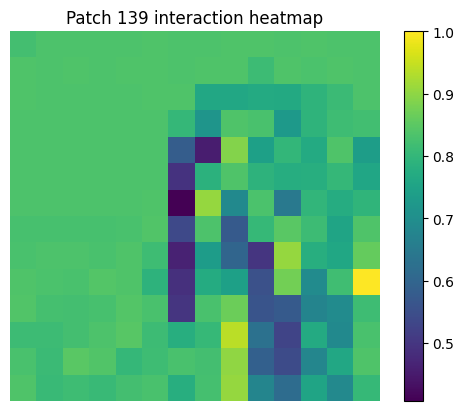

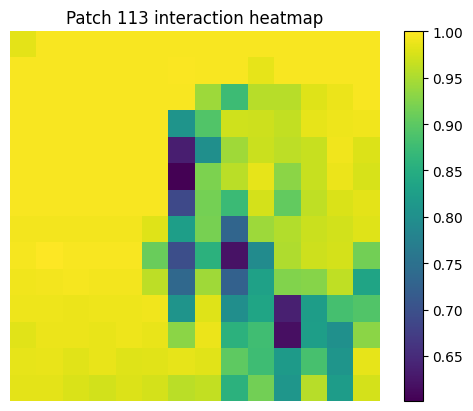

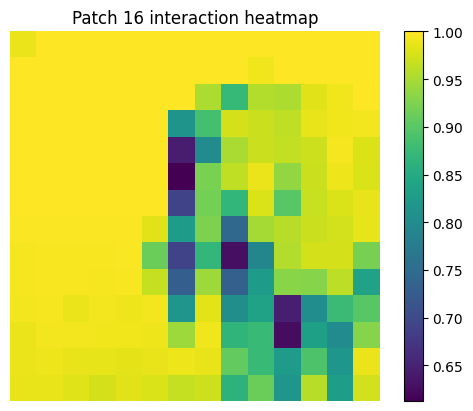

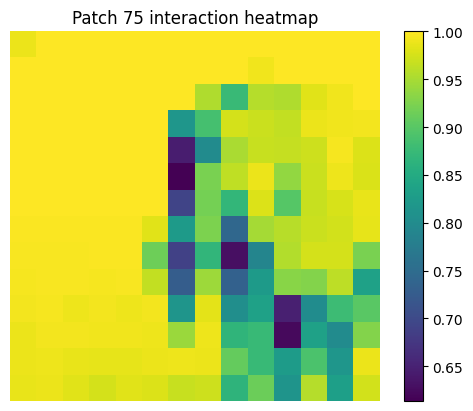

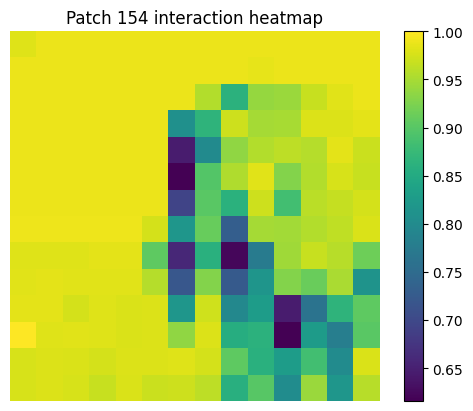

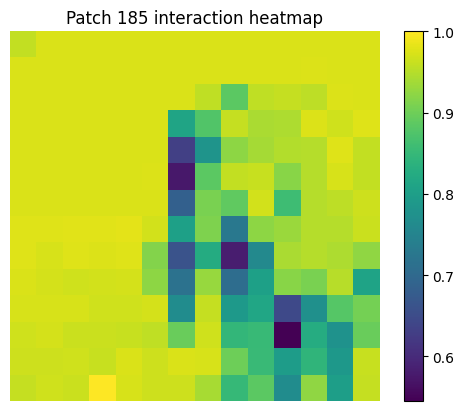

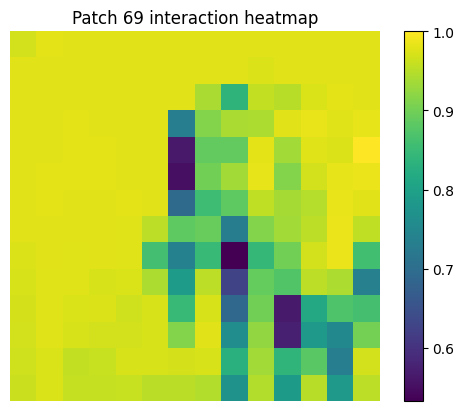

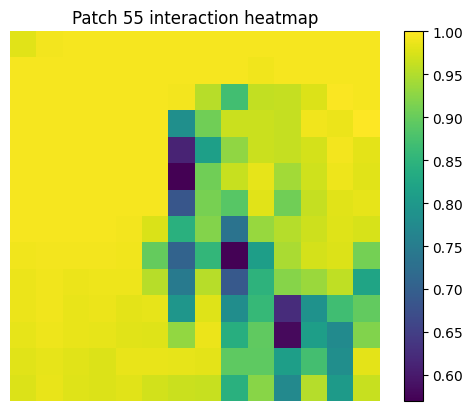

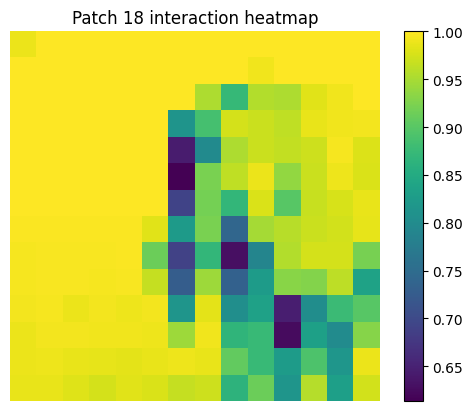

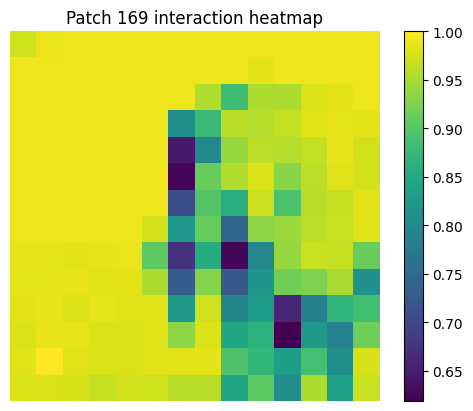

In [28]:
np.random.seed(42)
random_ks = np.random.choice(196, size=10, replace=False)

for k in random_ks:
    visualize(M, k)